# PROJECT: METROPOLIS MC 2D ISING MODEL

In [11]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

1. Monte Carlo Algorithm (slide 5 from presentation)

In [12]:
""""
· Initialization:
Initialize a $N\times N$ lattice with spins having +1 or -1 orientation

· Calculations:
Compute total energy using nearest-neighbour summation with periodic boundary conditions (PBCs) as well as total magnetization

· Metropolis Step:
Choose a random spin and compute the change in energy $\Delta E$
Acceptance probability that satisfies detailed balance given by:
    \begin{equation}
      P_{acc} = \min(1, e^{-\Delta E/T})
    \end{equation}
Apply Metropolis acceptance criterion:
If $\Delta E<0$ or if rand $<e^{-\Delta E/T}$:
    flip the spin
    add $\Delta E$ to the total energy
    add $\Delta M$ to the total magnetization
Repeat process for a sufficient number of steps

· Note: dimensionless units are being used so J is omitted because J=1
"""


# Function to generate initial configuration for NxN spins in a square lattice
def lattice(N):
    np.random.seed(45)
    return np.random.choice(np.array([-1, 1], dtype=np.int8), size=(N, N), p=[0.25, 0.75])  # Use p=[] to bias lattice with derised probability for each orientiation

# Function to get the total energy of the system (Hamiltonian in slide 4 from presentation; Equation 1)
@njit
def get_energy(lattice):
    N = lattice.shape[0] # Give the function the size of lattice
    energy = 0
    for i in range(N):
        for j in range(N):
            spin = lattice[i, j] # Spin orientation (+1 or -1) at lattice site (i,j)
            neighbours = (
                lattice[(i - 1) % N, j] + lattice[(i + 1) % N, j] + # This is the sum over nearest neighbours we see in the Hamiltonian
                lattice[i, (j - 1) % N] + lattice[i, (j + 1) % N]   # PBC:s are taken into account with the % operator
            )
            energy -= spin * neighbours # H = -spin*neighbours
    return energy / 2  # Divide by 2 because each pair of spins is being counted twice

# Metropolis Monte Carlo function
@njit
def MC(lattice, T, steps, snapshot_steps=None):
    np.random.seed(45)
    N = lattice.shape[0]
    configuration = lattice.copy() # Give our initial configuration and make a copy so we do not lose it since python passes by reference
    energy = get_energy(configuration) # Give the function to get the enrgy
    magnetization = np.sum(configuration) # Calculate the total magnetization (sum of all spins)
    
    # Storage and tracking:
    E_traj = np.zeros(steps) # Energy over MC steps
    M_traj = np.zeros(steps) # Magnetization over MC steps
    if snapshot_steps is not None:
        snapshots = {} # Snapshots of our configuration over MC steps
    
    
    #Metropolis steps
    for step in range(steps):
        # Choose a random spin
        i = np.random.randint(N)
        j = np.random.randint(N)

        # Compute change in energy if spin is flipped
        spin = configuration[i, j]
        neighbours = (
            configuration[(i - 1) % N, j] + configuration[(i + 1) % N, j] +
            configuration[i, (j - 1) % N] + configuration[i, (j + 1) % N]
        )
        dE = 2 * spin * neighbours # dE = E_new - E_old = -(-spin)*neighbours + (+spin)*neighbours = 2*spin*neighbours

        # Apply Metropolis acceptance criterion
        if dE < 0 or np.random.rand() < np.exp(-dE/T): 
            configuration[i, j] *= -1  # Flip the spin
            energy += dE # Add dE to the total energy
            magnetization -= 2*spin # Add dM to the total magnetization
                                    # dM = M_new - M_old = -spin - (+spin) = -2*spin

        # More storage:
        E_traj[step] = energy
        M_traj[step] = magnetization
        if snapshot_steps is not None and step in snapshot_steps:
            snapshots[step] = configuration.copy()

    
    if snapshot_steps is not None:
        return configuration, E_traj, M_traj, snapshots
    else:
        return configuration, E_traj, M_traj, None


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_56027/2362185135.py:1: SyntaxWarning: invalid escape sequence '\D'
  """"


2. 2D Ising Model Simulation for a NxN system at a given temperature

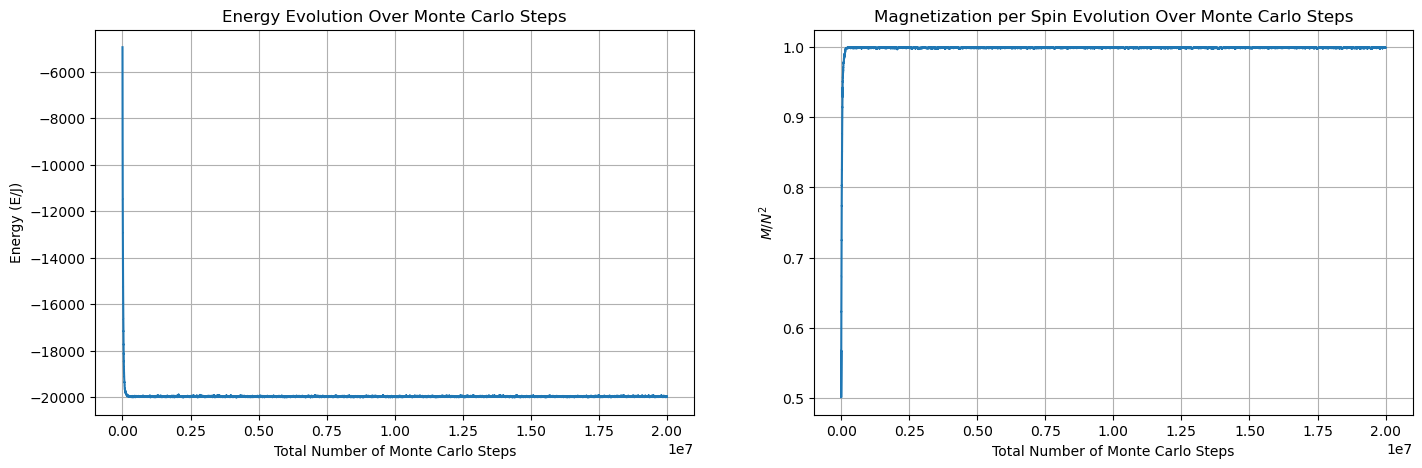

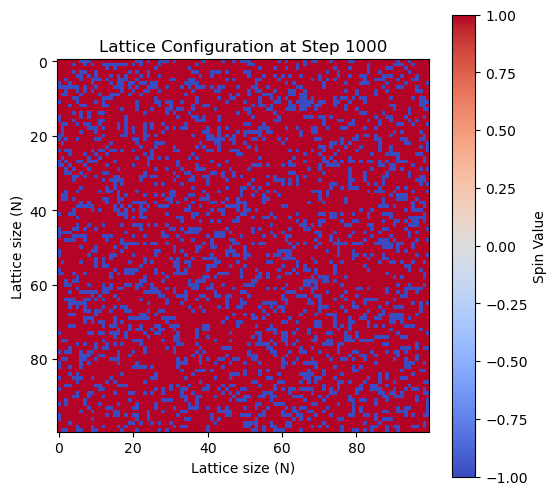

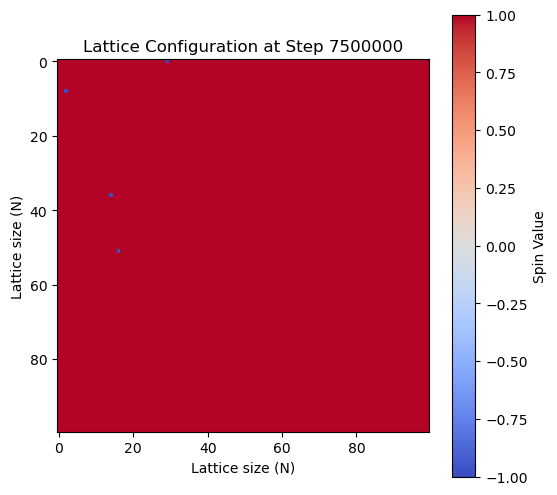

In [ ]:
# Variables
T = 1 # Temperature
N = 100   # Lattice size (change between 10, 50 and 100 to see configuration for each system)

# Run simulations for X steps
steps = 20000000
snapshot_steps = [1000, 7500000]  # To print our configuration at a desired step
x0 = lattice(N) # Initial conditions
configuration, energy, magnetization, snapshots = MC(x0, T, steps, snapshot_steps=snapshot_steps)

# Plot energy and magnetization over MC so that we are able to see when our system equilibrates
""""
The final number of steps as well as the equilibrium steps were chosen regarding the bigger system at T=T_c=2.30 (it's the one that takes the most
time to equilibrate) paying special attention at the magnetization. It is difficult to get it to fluctuate at a stable mean around cero because 
the system is at the phase transition so it has not reached the disordered phase yet. The maximum number of steps I could go without the kernel 
dying were 2.0e7 and setting the equilibrium steps at 7,500,000 onwards is what I found yielded the better results when plotting the 
observables for tasks 2,3 and 4
"""
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(steps), energy)
plt.xlabel("Total Number of Monte Carlo Steps")
plt.ylabel("Energy (E/J)")
plt.title("Energy Evolution Over Monte Carlo Steps")
plt.grid()

plt.subplot(1, 2, 2)
M_per_spin = magnetization/N**2  #M/total spins
#equilibrium_steps = range(7500000, steps) # Not used 
#M_per_spin_eq = M_per_spin[equilibrium_steps] #M/total spins after equilibrium (not used)
plt.plot(np.arange(steps), M_per_spin)
plt.xlabel("Total Number of Monte Carlo Steps")
plt.ylabel(r'$M/N^2$')
plt.title("Magnetization per Spin Evolution Over Monte Carlo Steps")
plt.grid()


# TASK 1: Study how the spin-configuration changes from an initial random state to equilibration at T=1
# i.e. plots the snapshots of our configuration for step = 1000 and step = 7,500,000
for step in snapshot_steps:
    plt.figure(figsize=(6, 6))
    plt.imshow(snapshots[step], cmap='coolwarm', interpolation='nearest')
    plt.xlabel("Lattice size (N)")
    plt.ylabel("Lattice size (N)")
    plt.title(f'Lattice Configuration at Step {step}')
    plt.colorbar(label='Spin Value')
    plt.show()



# If you want to visualize the configuration at the very beginning and at the very end
#plt.figure(figsize=(6, 6))
#plt.imshow(x0, cmap='coolwarm', interpolation='nearest')
#plt.title('Initial Lattice Configuration')
#plt.colorbar(label='Spin Value')
#plt.show()

#plt.figure(figsize=(6, 6))
#plt.imshow(configuration, cmap='coolwarm', interpolation='nearest')
#plt.xlabel("Lattice size (N)")
#plt.ylabel("Lattice size (N)")
#plt.title('Final Lattice Configuration')
#plt.colorbar(label='Spin Value')


plt.show()

3. MC Simulation to run various NxN Isisng systems and plot their observables for a given range of temperatures

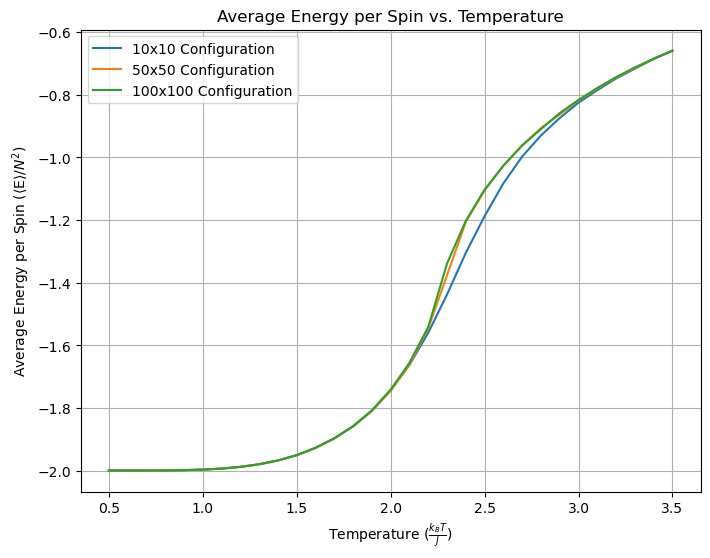

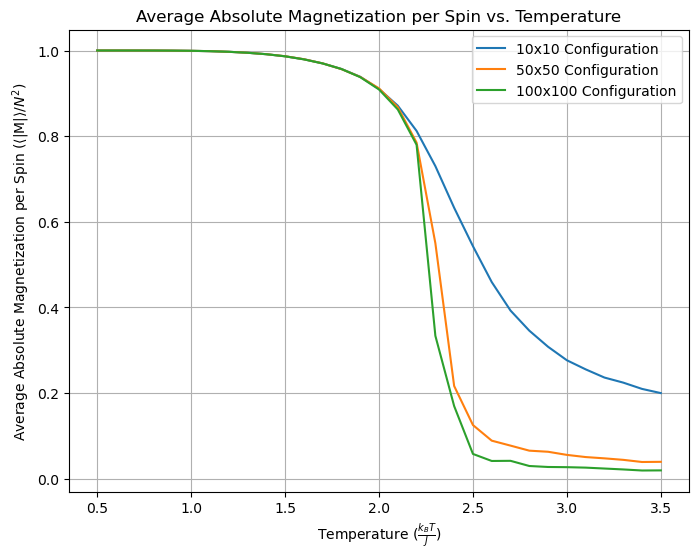

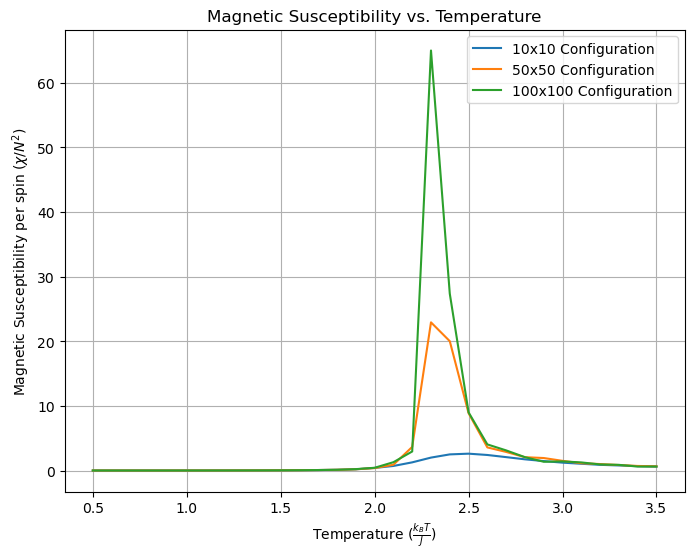

In [14]:
# Variables
temperatures = np.arange(0.5, 3.6, 0.1)
lattice_sizes = [10, 50, 100]
steps = 20000000
equilibrium_steps = range(7500000, steps)

# Storage
results = {"Energy": {}, "Magnetization": {}, "Susceptibility": {}}

# Loop over lattice sizes and temperatures
for N in lattice_sizes:
    # Storage for following averages
    energy_avg = []
    magnetization_avg = []
    susceptibility_avg = []
    
    for T in temperatures:
        # Use our MC function
        x0 = lattice(N) 
        configuration, energy, magnetization, _ = MC(x0, T, steps)

        # Calculate energy and magnetization after equilibrium
        E_eq = energy[equilibrium_steps]
        M_eq = magnetization[equilibrium_steps]
        
        # Calculations
        E_avg_per_spin = np.mean(E_eq)/N**2 # Average energy per spin
        abs_M_eq = np.abs(M_eq)  # Take absolute value of magnetization 
                                 # (so we counter act the averaging out that spontaneous flip in magnetization would cause)
        abs_M_avg_per_spin = np.mean(abs_M_eq)/N**2  # Average absolute magnetization per spin
        M_sq_avg = np.mean(M_eq**2)/N**2 # Average squared magnetization
        susceptibility = (M_sq_avg-(abs_M_avg_per_spin**2)*N**2)/T
        
        # Storage
        energy_avg.append(E_avg_per_spin)
        magnetization_avg.append(abs_M_avg_per_spin)
        susceptibility_avg.append(susceptibility)
    
    # To save results
    results["Energy"][N] = energy_avg
    results["Magnetization"][N] = magnetization_avg
    results["Susceptibility"][N] = susceptibility_avg



# TASK 2: Plot and compare the average energy per spin in the three systems
plt.figure(figsize=(8, 6))
for N in lattice_sizes:
    plt.plot(temperatures, results["Energy"][N], label=f"{N}x{N} Configuration")
plt.xlabel("Temperature " r'$(\frac{k_B T}{J})$')
plt.ylabel("Average Energy per Spin (⟨E⟩/"r'$N^2)$')
plt.title("Average Energy per Spin vs. Temperature")
plt.legend()
plt.grid()

# TASK 3: Plot and compare the average magnetization per spin for three spin systems
plt.figure(figsize=(8, 6))
for N in lattice_sizes:
    plt.plot(temperatures, results["Magnetization"][N], label=f"{N}x{N} Configuration")
plt.xlabel("Temperature " r'$(\frac{k_B T}{J})$')
plt.ylabel("Average Absolute Magnetization per Spin (⟨|M|⟩/"r'$N^2)$')
plt.title("Average Absolute Magnetization per Spin vs. Temperature")
plt.legend()
plt.grid()

# TASK 4: Plot and compare the susceptibility for the three spin systems
plt.figure(figsize=(8, 6))
for N in lattice_sizes:
    plt.plot(temperatures, results["Susceptibility"][N], label=f"{N}x{N} Configuration")
plt.xlabel("Temperature " r'$(\frac{k_B T}{J})$')
plt.ylabel("Magnetic Susceptibility per spin " r'$(\chi/N^2)$')
plt.title("Magnetic Susceptibility vs. Temperature")
plt.legend()
plt.grid()




plt.show()

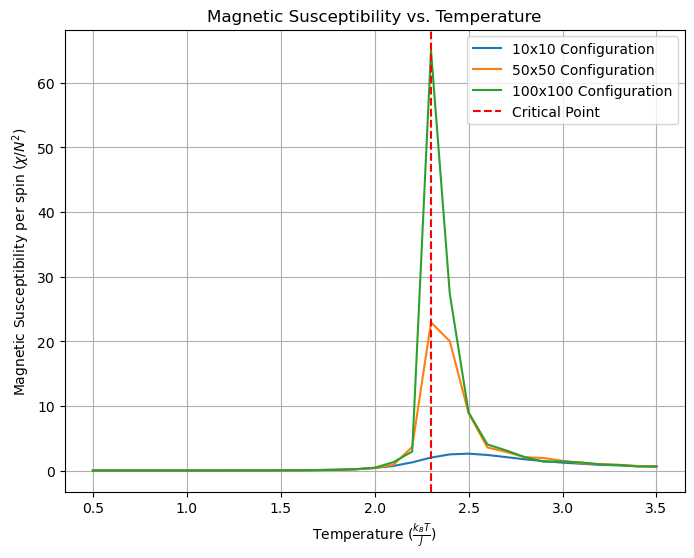

In [15]:
# So that we can observe (approximately) the point at which our system changes between phases
plt.figure(figsize=(8, 6))
for N in lattice_sizes:
    plt.plot(temperatures, results["Susceptibility"][N], label=f"{N}x{N} Configuration")
plt.axvline(x=2.30, color='r', linestyle='--', label="Critical Point")
plt.xlabel("Temperature " r'$(\frac{k_B T}{J})$')
plt.ylabel("Magnetic Susceptibility per spin " r'$(\chi/N^2)$')
plt.title("Magnetic Susceptibility vs. Temperature")
plt.legend()
plt.grid()
plt.show()
